# Part 3: quantifying the decrease in electricity usage and finding its cause

In [1]:
from mysql.connector import MySQLConnection, Error
import pandas as pd
from sqlalchemy import create_engine 
import pymysql
import datetime
import numpy as np
import matplotlib.pyplot as plt

from connection_config import read_db_config
from plot_gov_events import plot_government_events
from normality_test import normality_test

## Look into the oxford stringency data
To find the time window where Covid impact was most severe, we used the oxford stringency index. The stringency index records the strictness of ‘lockdown style’ policies that primarily restrict people’s behaviour.

In [2]:
# Downloading from database, focus on UK overall
conn_string,ssl_args = read_db_config('teama.teama')
engine = create_engine(conn_string,connect_args=ssl_args)
oxford_stringency_df = pd.read_sql('SELECT * FROM oxford_stringency_raw WHERE CountryCode = "GBR" AND RegionName IS NULL', con=engine)

In [3]:
oxford_stringency_df.head()

,index,Unnamed: 0,CountryName,CountryCode,RegionName,RegionCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,...,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,15616,15616,United Kingdom,GBR,None,None,20200101,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15617,15617,United Kingdom,GBR,None,None,20200102,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15618,15618,United Kingdom,GBR,None,None,20200103,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15619,15619,United Kingdom,GBR,None,None,20200104,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15620,15620,United Kingdom,GBR,None,None,20200105,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Can remove index, unnamed, region name, region code, country code 
oxford_stringency_df=oxford_stringency_df.drop(["index","Unnamed: 0","CountryCode","RegionName","RegionCode"],axis = 1)

In [5]:
# Look what data is in the database
oxford_stringency_df.dtypes

CountryName                               object
Date                                       int64
C1_School closing                        float64
C1_Flag                                  float64
C2_Workplace closing                     float64
C2_Flag                                  float64
C3_Cancel public events                  float64
C3_Flag                                  float64
C4_Restrictions on gatherings            float64
C4_Flag                                  float64
C5_Close public transport                float64
C5_Flag                                  float64
C6_Stay at home requirements             float64
C6_Flag                                  float64
C7_Restrictions on internal movement     float64
C7_Flag                                  float64
C8_International travel controls         float64
E1_Income support                        float64
E1_Flag                                  float64
E2_Debt/contract relief                  float64
E3_Fiscal measures  

In [6]:
# need to reformat date into datetime
oxford_stringency_df['Date']= pd.to_datetime(oxford_stringency_df['Date'], format='%Y%m%d')

 ## Plot stringency index against covid policy changes
 Source of policy dates is [here](https://www.health.org.uk/news-and-comment/charts-and-infographics/covid-19-policy-tracker).

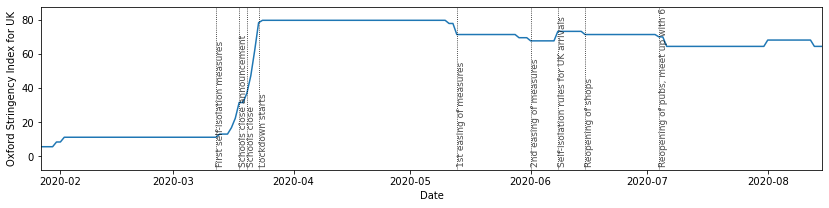

In [115]:
fig, ax = plt.subplots(figsize=(14,3))
ax.set_xlabel('Date')
ax.set_ylabel('Oxford Stringency Index for UK')
ax.plot(oxford_stringency_df['Date'], oxford_stringency_df['StringencyIndex'])
# change range 
ax.set_xlim([datetime.date(2020, 1, 27), datetime.date(2020, 8, 15)])
# add government events
plot_government_events()
    
ax.margins(0.1)

The stringency index is high when there are many restrictions. For our analysis, we are going to investigate the change in electricity behaviour between the first self-isolation measures on the <strong>12th of March</strong> and the second easing of measures on the <strong>1st of June</strong>.

## Load model results

In [35]:
model_result_df = pd.read_sql('SELECT * FROM model_only_load_2015_2020_tuned_trained_2015_2019', con=engine)
model_result_df = model_result_df.drop(["index"],axis=1)
model_result_df.head()

,Timestamp,Predicted,Actual
0,2015-01-01,34477.384361,28312.104167
1,2015-01-02,37739.850193,30855.979167
2,2015-01-03,37398.541970,31009.833333
3,2015-01-04,36865.903208,30924.687500
4,2015-01-05,40834.548325,41563.562500


## Quantify difference between 12/03 and 01/06

In [36]:
start_lockdown_index = model_result_df[model_result_df["Timestamp"]==datetime.date(year=2020,month=3,day=12)].index.values
end_lockdown_index = model_result_df[model_result_df["Timestamp"]==datetime.date(year=2020,month=6,day=1)].index.values

In [37]:
lockdown_load = model_result_df.iloc[start_lockdown_index[0]:end_lockdown_index[0]+1]
lockdown_load.tail()

,Timestamp,Predicted,Actual
1973,2020-05-28,32493.080047,29638.416667
1974,2020-05-29,32099.464594,28816.750000
1975,2020-05-30,29114.334078,25443.083333
1976,2020-05-31,28418.388291,25307.687500
1977,2020-06-01,32209.762145,28984.625000


Statistics=0.962, p=0.015
Sample does not look Gaussian (reject H0)
Statistics=0.981, p=0.282
Sample looks Gaussian (fail to reject H0)


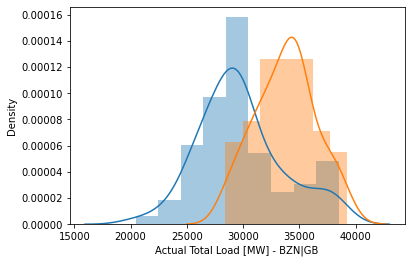

In [44]:
# Check normality
normality_test(lockdown_load["Actual"])
normality_test(lockdown_load["Predicted"])

In [57]:
# Will use median to describe drop as actual distribution not normal
difference = (lockdown_load["Predicted"].median() - lockdown_load["Actual"].median())/ lockdown_load["Predicted"].median()*100
print('Drop in median electricity usage between the 12th of March and the 1st of June: %.3f' % difference, '%.')

Drop in median electricity load between the 12th of March and the 1st of June: 14.213 %.


## What caused decreases in electricity usage?
We have found a <strong>14% decrease</strong> in electricity usage during covid compared to what it would have been if Covid hadn't happened. What caused this? 
To explore the bahviour of people, we used apple and google mobility data. 

In [119]:
apple_mob_uk = pd.read_sql('SELECT * FROM applemobilitytrends_raw WHERE region = "United Kingdom"', con=engine)
apple_mob_uk = apple_mob_uk.iloc[:,7:]
transpose_df = apple_mob_uk.transpose()
transpose_df = transpose_df.rename(columns={0: 'driving', 1:"transit",2:"walking"})
transpose_df=transpose_df.reset_index()
transpose_df['Date']= pd.to_datetime(transpose_df['index'], format='%Y-%m-%d')

(737451.0, 737652.0)

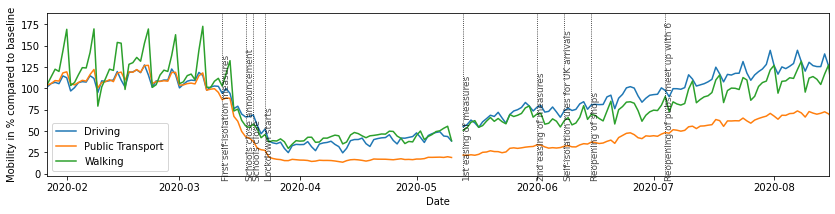

In [125]:
fig, ax = plt.subplots(figsize=(14,3))

plt.plot(transpose_df["Date"], transpose_df['driving'], label='Driving')
plt.plot(transpose_df["Date"], transpose_df['transit'], label='Public Transport')
plt.plot(transpose_df["Date"], transpose_df['walking'], label='Walking')
plt.xlabel('Date')
plt.ylabel('Mobility in % compared to baseline')
plt.legend()
plot_government_events()
ax.margins(0.1)
plt.xlim([datetime.date(2020, 1, 27), datetime.date(2020, 8, 15)])


Apple's mobility data highlights that already on the weekend of the 14th and 15th of March 2020, people's mobility decreased compared to the weekends before. Since government policies to combat COVID-19 properly started the week after, one could argue that people reduced their mobility without government mandates. This might be because of the prominence of COVID-19 in the news, making people reconsider meeting with friends and to avoid crowded places. Related to avoiding crowded places, one effect of the pandemic is the decrease in usage of public transport. Work from home orders might play a role here, reducing the need to commute to work with public transport. 

This decrease in public transport usage could be reflected in the fact that the volume of driving from July onwards tends to be higher than the baseline volume on 13 January 2020. 

## Google mobility data
We can get more insight into the behaviour of people from Google's mobility data, which is quantified in a slightly different way than apple's data. Focusing on the whole of UK again.

In [129]:
google_mob_df = pd.read_sql('SELECT * FROM Google_Global_Mobility_Report_raw WHERE country_region = "United Kingdom" AND sub_region_1 IS NULL', con=engine)
google_mob_df.head()

,index,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,850033,GB,United Kingdom,None,None,None,None,None,2020-02-15,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
1,850034,GB,United Kingdom,None,None,None,None,None,2020-02-16,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
2,850035,GB,United Kingdom,None,None,None,None,None,2020-02-17,10.0,1.0,24.0,-2.0,-14.0,2.0
3,850036,GB,United Kingdom,None,None,None,None,None,2020-02-18,7.0,-1.0,20.0,-3.0,-14.0,2.0
4,850037,GB,United Kingdom,None,None,None,None,None,2020-02-19,6.0,-2.0,8.0,-4.0,-14.0,3.0


In [131]:
google_mob_df['date']= pd.to_datetime(google_mob_df['date'], format='%Y-%m-%d')

(737451.0, 737652.0)

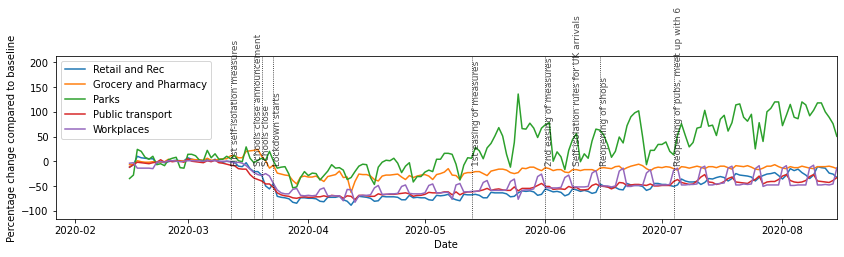

In [135]:
fig, ax = plt.subplots(figsize=(14,3))
plt.plot(google_mob_df['date'], google_mob_df['retail_and_recreation_percent_change_from_baseline'], label='Retail and Rec')
plt.plot(google_mob_df['date'], google_mob_df['grocery_and_pharmacy_percent_change_from_baseline'], label='Grocery and Pharmacy')
plt.plot(google_mob_df['date'], google_mob_df['parks_percent_change_from_baseline'], label='Parks')
plt.plot(google_mob_df['date'], google_mob_df['transit_stations_percent_change_from_baseline'], label='Public transport') 
plt.plot(google_mob_df['date'], google_mob_df['workplaces_percent_change_from_baseline'], label='Workplaces')                         
plt.xlabel('Date')
plt.ylabel('Percentage change compared to baseline')
plt.legend()
plot_government_events()
ax.margins(0.1)
plt.xlim([datetime.date(2020, 1, 27), datetime.date(2020, 8, 15)])
